## Comparing model score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 글꼴깨짐 방지
import matplotlib
import matplotlib.font_manager as fm

import warnings

# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [2]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

In [3]:
import joblib
import xgboost as xgb

catboost_model = joblib.load('./Catboost_GridSearchCV_model.pkl')
xgboost_model = xgb.XGBRegressor()
xgboost_model.load_model('xgb_model.model')
lightgbm_model = joblib.load('./lightgbm.pkl')

In [4]:
df = pd.read_csv('train.csv')

In [5]:
def preprocessing(df):
    # 오류 단지코드가 존재하는 행들을  사전에 제거
    df_error =  ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
    #df_error =  ['C2335', 'C1327']
    df = df[~df['단지코드'].isin(df_error)].reset_index(drop=True)
    df.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철','도보 10분거리 내 버스정류장 수':'버스'},inplace=True)
    df.drop(columns=['임대보증금','임대료','자격유형','임대건물구분'],axis = 1,inplace=True)
    지역_비율 = (df.groupby(['지역'])['총세대수'].count())/(df.groupby(['지역'])['총세대수'].count().sum())*100
    지역_비율=지역_비율.reset_index(name='지역_비율')
    공급유형_비율 = (df.groupby(['공급유형'])['총세대수'].count())/(df.groupby(['공급유형'])['총세대수'].count().sum())*100
    공급유형_비율=공급유형_비율.reset_index(name='공급유형_비율')
    df = pd.merge(df,지역_비율, on='지역')
    df = pd.merge(df,공급유형_비율, on='공급유형')
    df.drop(columns=['지역','공급유형','단지코드'],axis = 1,inplace=True)
    df=df.dropna(axis=0)
    df = df[['총세대수', '전용면적', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '공급유형_비율',
       '지역_비율', '등록차량수']]
    return df

In [6]:
df = preprocessing(df)

In [7]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

### train set, test set

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
base = X_test
target = y_test

## Evaluating Model

In [10]:
mae_dict = dict()

In [11]:
def evaluate_model(model):
    pred = model.predict(base)
    return mean_absolute_error(target, pred)

### base model: LinearRegression

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

mae_dict['LinearRegression'] = evaluate_model(lr)

### CatBoost

In [13]:
mae_dict['CatBoost'] = evaluate_model(catboost_model)

### XGBoost

In [14]:
mae_dict['XGBoost'] = evaluate_model(xgboost_model)

### LightGBM

In [15]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
train_data_standardScaled = standardScaler.fit_transform(df)

X = pd.DataFrame(train_data_standardScaled).iloc[:, 1:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pred = lightgbm_model.predict(X_test)
mae_dict['LightGBM'] = mean_absolute_error(y_test, pred)

### CNN

In [16]:
mae_dict['CNN'] = 117.19342498779297

## Visualization

In [17]:
mae_dict

{'LinearRegression': 150.81692600640224,
 'CatBoost': 36.84444338132358,
 'XGBoost': 25.76014966982481,
 'LightGBM': 57.882127508737405,
 'CNN': 117.19342498779297}

In [18]:
mae_key = list(mae_dict.keys())
mae_value = list(mae_dict.values())

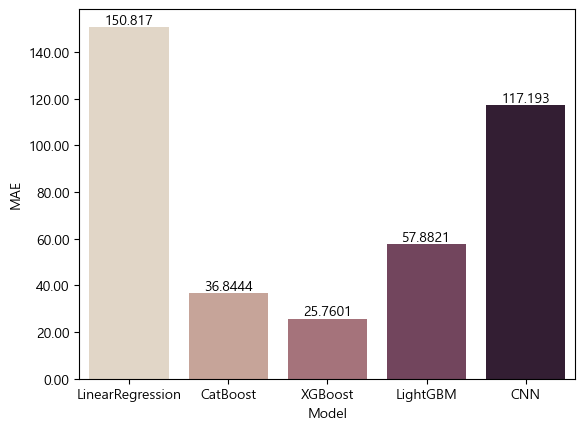

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax = sns.barplot(x=mae_key, y=mae_value, palette="ch:.25")
plt.xlabel('Model')
plt.ylabel('MAE')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()